<a href="https://colab.research.google.com/github/YelisettyRahul/CryptoCurrency-_Prediction/blob/main/CryptoCurrency__Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data']) # API of data used for predection
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [ ]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [ ]:
hist.head(1000) # tabular representation of data

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2021-12-14,62717.46,59209.99,59936.73,3874.17,2.345867e+08,62348.13
2021-12-15,63705.07,59957.30,62348.13,4037.22,2.500769e+08,62857.11
2021-12-16,63330.12,60572.73,62857.11,3133.99,1.952290e+08,60755.16
2021-12-17,61529.42,58313.91,60755.16,4096.66,2.474348e+08,59684.29
2021-12-18,61155.13,58552.88,59684.29,3366.64,2.024930e+08,60236.94
...,...,...,...,...,...,...
2023-04-24,37773.89,36572.81,37243.44,78.69,2.921504e+06,37212.06
2023-04-25,38621.90,36843.92,37212.06,71.00,2.665898e+06,38407.95
2023-04-26,40777.28,37373.84,38407.95,97.30,3.803054e+06,38736.84


In [ ]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data # training and testing of data

In [ ]:
train, test = train_test_split(hist, test_size=0.2)

In [ ]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=3):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16); # representation of data to be predected in graphical form

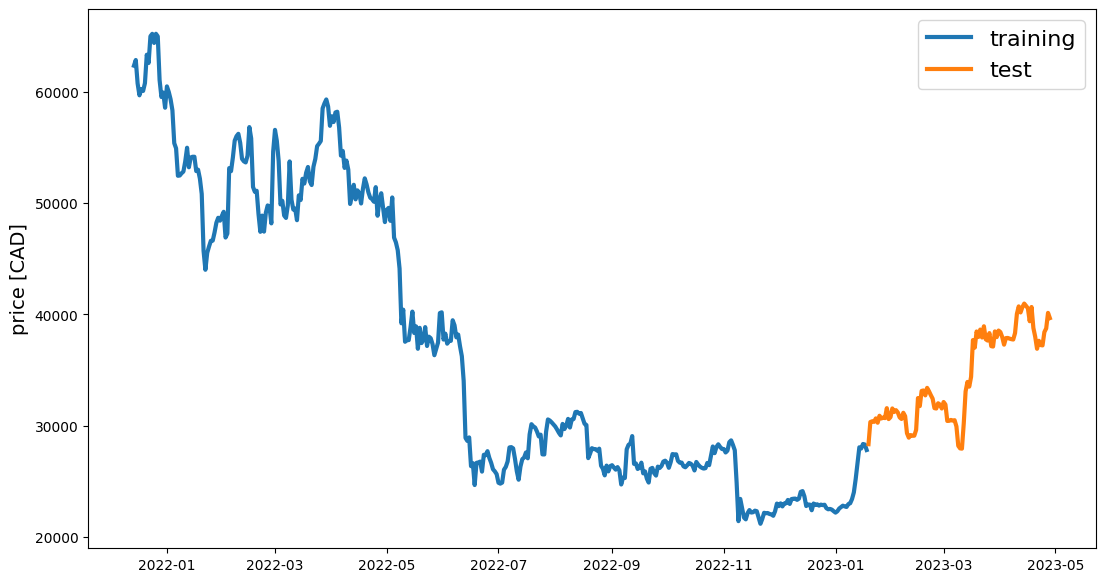

In [ ]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [ ]:
def normalise_zero_base(df):#The goal of normalization is to transform features to be on a similar scale
#This improves the performance and training stability of the model.
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [ ]:
def extract_window_data(df, window_len=6, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)#Function extracting the data from original data to normalized form
        window_data.append(tmp.values)
    return np.array(window_data)

In [ ]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)#After extraction of data we defne this function for prepare it for training and testing
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 20
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'#Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure.
#update network weights iterative based in training data.

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [ ]:
model = build_lstm_model(#to run the data of bitcoin around the algorithm where the epoch concept is applied.
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
13/13 [==============================] - 3s 60ms/step - loss: 0.0051 - val_loss: 0.0030
Epoch 2/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0041 - val_loss: 0.0023
Epoch 3/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 4/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 5/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 6/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 7/20
13/13 [==============================] - 0s 9ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 8/20
13/13 [==============================] - 0s 11ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 9/20
13/13 [==============================] - 0s 10ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 10/20
13/13 [==============================] - 0s 12ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 11/20


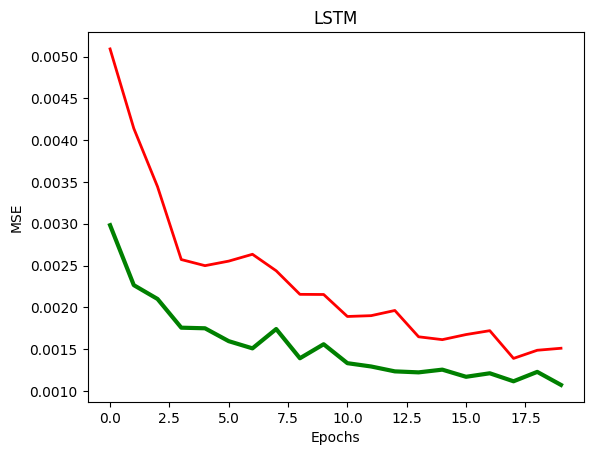

In [ ]:
import matplotlib.pyplot as plt #to display the accuracy of LSTM
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')#The training loss is a metric used to assess how a deep learning model fits the training data.
plt.plot(history.history['val_loss'], 'g',linewidth=3, label='Validation loss')#The validation set is a portion of the dataset set aside to validate the performance of the model.
plt.title('LSTM')
plt.xlabel('Epochs')#x-axis represent the data to 20 epoch
plt.ylabel('MSE') #y-axis gives the mean square error of 20 times Epoch
plt.show()

In [ ]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test) #error refers to the magnitude of difference between the prediction of an observation and the true value of that observation.

3/3 [==============================] - 0s 6ms/step


0.022027511076163363

In [ ]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test) #The mean squared error is a common way to measure the prediction accuracy of a model.
MAE

0.0010720044922828901

In [ ]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2#to evaluate the performance of a linear regression model.

0.7782994467870865

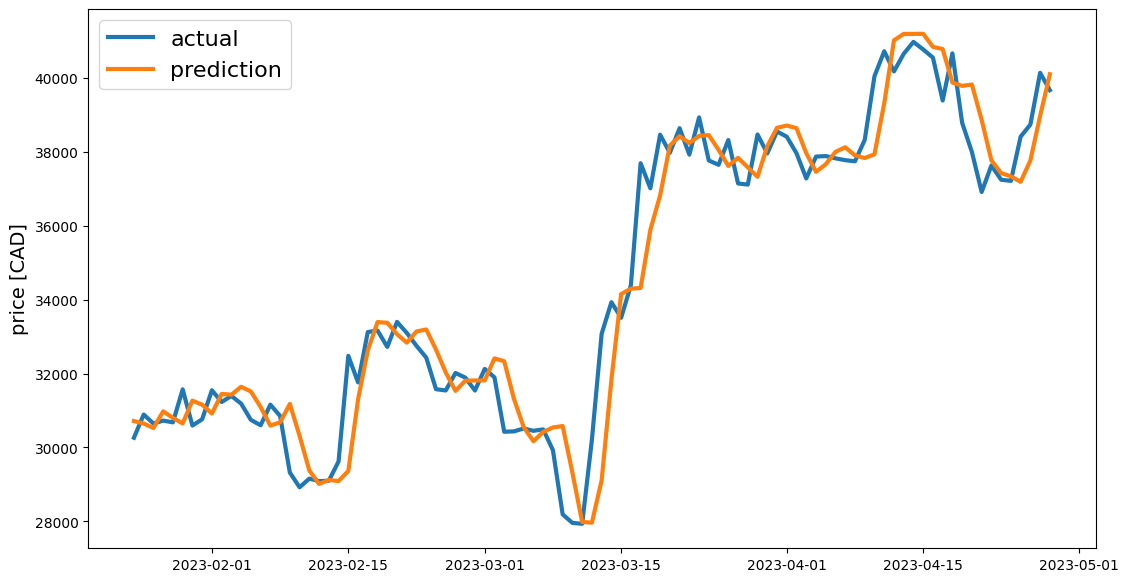

In [ ]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)#display the final out of prediction and comparing the predicted data with actual data